#  Preparing estimates of daily Covid cases in Devon

### Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum


### Script functionality
This script converts the weekly data showing the number of new positive test results in the last 7 day period into an estimate of the number of new cases each day.  

This conversion process includes the following steps:
* Shifting the data back in time by 6 days (to account for a testing lag)  
* Multiplying the data by a month-specific multiplier (to account for not all cases being picked up by testing)  
* Linearly interpolating from weekly to daily data 
* Smoothing the data  

Daily estimates of cases are calcualted for both Devon as a whole and each MSOA seperately.

In [1]:
## Set up python environment
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np  
import matplotlib.cm as cm
from csaps import csaps

## Download COVID test data for the UK from government website

In [2]:
# Define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
# Download data
df = pd.read_csv(new_url)

## Keep only data for MSOAs in Devon, and reformat
Use msoa_codes of msoas in devon to filter the data

In [3]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

# Convert to datetime
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'])

# Sort by date (again!)
weekly_cases_msoas.sort_values(by='Date', inplace =True)
weekly_cases_msoas.head()

,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004204,2020-03-25,3
E02004193,2020-03-25,3
E02004160,2020-04-01,6
E02004140,2020-04-01,3
E02004162,2020-04-01,3
...,...,...
E02004180,2022-01-26,95
E02004181,2022-01-26,69
E02004182,2022-01-26,73


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [4]:
# Create dataframe containing the dates for which there are data in at least one MSOA
# dates = pd.DataFrame({'Date':weekly_cases_msoas['Date'].unique()})
# CReate dataframe containing all dates that exist in this timeframe (to take account for fact some weeks 
# have no cases in ANY of the msoas)
dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-25', end = '2021-05-19', freq='W-Wed')})

# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)
# reindex
weekly_cases_msoas = weekly_cases_msoas.reset_index(drop = True)
weekly_cases_msoas.head()

,Date,E02004204,E02004193,E02004160,E02004140,E02004162,E02004151,E02004219,E02004202,E02004233,...,E02004200,E02004178,E02004224,E02004228,E02004129,E02004185,E02004135,E02004232,E02004212,E02004225
0,2020-03-25,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-01,NaN,5.0,6.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-08,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-15,NaN,4.0,4.0,NaN,NaN,4.0,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-22,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2021-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2021-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2021-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2021-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaNs with 0
This is where individual MSOAs didn't have data for some of the dates in the period

In [5]:
weekly_cases_msoas = weekly_cases_msoas.fillna(0)

## Combine data for whole of Devon

Create a dataframe containing info on cases across the WHOLE of Devon, with:  
* One column with dates
* One column with the number of new cases on each date
* One column with the cumulative number of cases so far on that date

In [6]:
# def find_devon_totals(df):
#     totals_df = df.copy()
#     # Add a row with the total number of cases across all MSOAs in each week
#     totals_df['OriginalCases']= totals_df.iloc[:, 1:].sum(axis=1)
#     # Remove columns with individual values for each MSOA
#     totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
#     totals_df.reset_index(inplace = True, drop = True)
# #     # Find the cumulative cases
# #     totals_df['CumulativeCases'] = totals_df['Total_obs'].cumsum()
# #     # Rename column
# #     totals_df.rename(columns={"Total_obs": "Cases"}, inplace = True)
#     # Sort by date
#     totals_df.sort_values(by='Date', inplace =True)
#     return totals_df
    
# weekly_cases_devon = find_devon_totals(weekly_cases_msoas) 
# weekly_cases_devon

,Date,OriginalCases
0,2020-03-25,6.0
1,2020-04-01,39.0
2,2020-04-08,73.0
3,2020-04-15,103.0
4,2020-04-22,96.0
...,...,...
56,2021-04-21,21.0
57,2021-04-28,37.0
58,2021-05-05,28.0
59,2021-05-12,29.0


## Plot data 
#### For each of the MSOAs individually (for a sample of the MSOAs)

In [24]:
# msoa_codes = weekly_cases_msoas.columns[1:]
# fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
# for i, ax in enumerate(fig.axes):
#     msoa_code = msoa_codes[i]
#     one_msoa = weekly_cases_msoas[['Date', msoa_code]]
       
#     ax.plot(one_msoa['Date'], one_msoa[msoa_code], label="Weekly (daily)", color="blue")
#     #ax.set_xlabel("Date", fontsize= 16)
#     #ax.set_xlabel("Date", fontsize= 16)
#     ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
#     ax.legend()
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
# fig.tight_layout()
# plt.show()

#### For whole of Devon

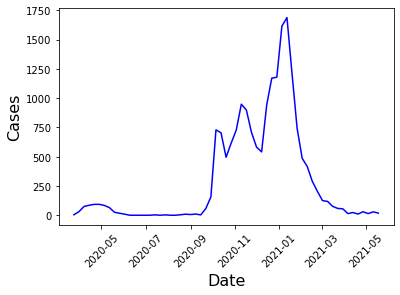

In [9]:
# # shared axis
# fig, ax = plt.subplots()
# plt.xlabel("Date", fontsize= 16)
# plt.ylabel("Cases", fontsize= 16)
# # plt.title("n")
# plt.xticks(rotation=45)
# plt.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Shifted cases", color="blue")


## Correcting observations 
2 issues with recorded positive case data:
1.	There is a lag between the time of a positive test result and the time of infection
2.	Tests do not pick up all positive cases

Can correct this by:
1.	Shifting positive test results back in time (based on data on lag between infection and positive result)
2.	Using a multiplier on the number of positive cases (based on data on the proportion of positive case results being picked up by tests)


In [8]:
# # keep only up to May 2021
# weekly_cases_devon_shifted = weekly_cases_devon.copy()

# def shift_cases(df, n_days):
#     # Shift back the date of the week by 6 days
#     df['Date'] =  df['Date'] -  timedelta(days=n_days)
#     # rename column
#     df = df.rename(columns={df.columns[1]: 'ShiftedCases'})
#     return df

# # shift cases
# weekly_cases_devon_shifted = shift_cases(weekly_cases_devon_shifted, 6)
# weekly_cases_devon_shifted.head()

,Date,ShiftedCases
0,2020-03-19,6.0
1,2020-03-26,39.0
2,2020-04-02,73.0
3,2020-04-09,103.0
4,2020-04-16,96.0


#### Plot the number of cases over time for original case data and time shifted case data

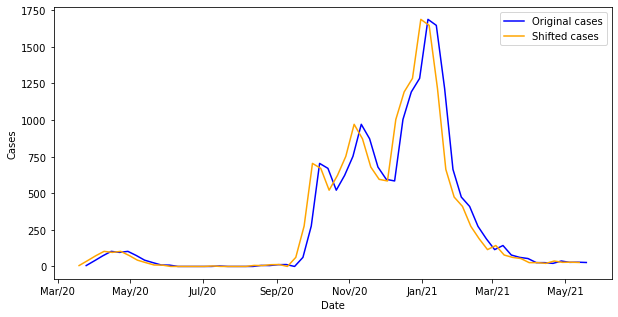

In [9]:
# # Define formatting for dates
# myFmt = mdates.DateFormatter('%b/%y')

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.xaxis.set_major_formatter(myFmt)
# # Plot observations
# ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="blue")
# ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="orange")
# # Plot result from manually calibrated model
# ax.legend()
# ax.xaxis.set_major_formatter(myFmt)
# # plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
# plt.xlabel("Date")
# plt.ylabel("Cases")
# plt.show()

### Correcting for lack of testing: Apply multipliers
Tests do not pick up all positive cases. Therefore data on positive test results will not be a good representation of the number of actual cases in the population. An improved estimate of the number of infections in the population can be acquired through applying a multiplier to the positive cases data. Multipliers are applied to the data here based upon outputs of research by Phipps et al (2020), who applied a backcasting approach to estimate the true distribution of Covid in the population, and derived multipliers through comparison of this to the positive case data.

**NB: I just took multipliers from graph roughly, need exact figures**

Phipps, S.J., Grafton, R.Q. and Kompas, T., 2020. Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach. Royal Society open science, 7(11), p.200909.

In [10]:
# # Define multipliers (roughly taken from paper)
# multipliers_dict = {'Mar2020':(100/3), 'Apr2020':(100/4),'May2020': (100/5), 'Jun2020':(100/6), 'Jul2020':(100/7), 
#                     'Aug2020':(100/8),'Sep2020':(100/9),'Oct2020':(100/9),
#                     'Nov2020':(100/9),'Dec2020':(100/9),'Jan2021':(100/9),'Feb2021':(100/9),
#                     'Mar2021':(100/9), 'Apr2021':(100/9),'May2021':(100/9)}

# # Loop through rows in cases datafrrame and check the month and year and then apply the correct multiplier
# # Save the results into a list
# def apply_multipliers(df):
#     df_shifted_mxpld = df.copy()
#     cases_col_name = list(df_shifted_mxpld.columns)
#     infections= []
#     for row in df_shifted_mxpld.itertuples():
#         month = row.Date.strftime("%b")
#         year = row.Date.strftime("%Y")
#         multiplier = multipliers_dict[month+year]
#         infections.append(row[2] * multiplier)

#     # Add column to dataframe using the list
#     df_shifted_mxpld['ShiftedInfections'] = infections
#     return df_shifted_mxpld

# weekly_cases_devon_shifted_mxpld = apply_multipliers(weekly_cases_devon_shifted)
# weekly_cases_devon_mxpld = apply_multipliers(weekly_cases_devon)

#### Plotting
The number of cases over time for original case data, time shifted case data and time shifted infections (cases * multipliers) 

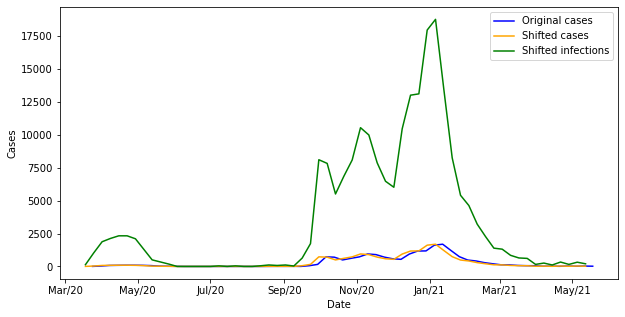

In [13]:
# # Define formatting for dates
# myFmt = mdates.DateFormatter('%b/%y')

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.xaxis.set_major_formatter(myFmt)
# # Plot observations
# ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="blue")
# ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="orange")
# ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Shifted infections", color="green")

# # Plot result from manually calibrated model
# ax.legend()
# ax.xaxis.set_major_formatter(myFmt)
# # plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
# plt.xlabel("Date")
# plt.ylabel("Cases")
# plt.show()


### Smoothing data
There is considerable noise (/outliers) in the recorded case data. To remove this, and to make patterns in the data more clear, the data can be smoothed using an algorithm.   

In this case, smoothing is achieved using a cubic smoothing spline. A cubic spline is a piecewise cubic function that interpolates a set of data points and guarantees smoothness at the data points. https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation

The smoothing parameter can be set manually and should be between 0 and 1. When 0, the smoothing spline is a least-squares straight line fit to the data, and when 1 it is the natural cubic spline interpolant (?). For 0 < p < 1, sp is a smoothing spline that is a trade-off between the two extremes: smoother than the interpolant s1 and closer to the data than the straight line s0.

https://towardsdatascience.com/numerical-interpolation-natural-cubic-spline-52c1157b98ac

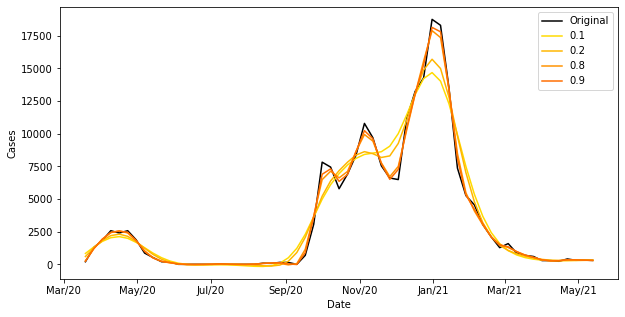

In [11]:
# Uses csaps package https://pypi.org/project/csaps/0.5.0/  

# Define function for smoothing
def smooth_with_cubic_splines(df, smooth_factor):
    df = df.copy()
    case_data = df['ShiftedInfections'].values
    case_data_locations = np.array(list(range(0, len(case_data))))
    xi = np.linspace(case_data_locations[0], case_data_locations[-1], len(case_data))
    df['SmoothedShiftedInfections'] = csaps(case_data_locations, case_data, xi, smooth=smooth_factor)
    return df

# Test different smoothness values
evenly_spaced_interval = np.linspace(0, 1, 8)
colors = [cm.autumn_r(x) for x in evenly_spaced_interval]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Original", color="black")
for color_i, smooth_factor in zip([1,2,3,4,5], [0.1,0.2,0.8, 0.9]):
    weekly_cases_devon_shifted_mxpld_smoothed = smooth_with_cubic_splines(weekly_cases_devon_shifted_mxpld,smooth_factor )
    color = colors[color_i]
    # Plot observations
    ax.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label=smooth_factor, color = color)
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

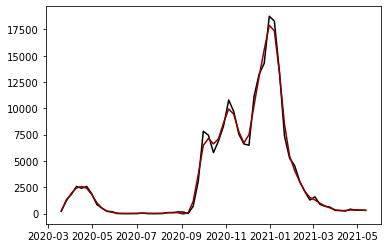

In [12]:
# Decide on smoothness factor,
# Add new column to dataframe, with smoothed version of shiftted infections data
smooth_factor =0.8
weekly_cases_devon_shifted_mxpld_smoothed =smooth_with_cubic_splines(weekly_cases_devon_shifted_mxpld.copy(), smooth_factor)
weekly_cases_devon_shifted_mxpld_smoothed.head()
plt.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Original", color="black")
plt.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label="Original", color="darkred")

#### Plotting

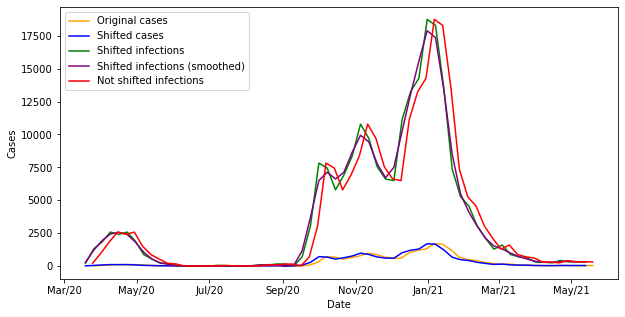

In [13]:
#Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
# Plot observations
ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="orange")
ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="blue")
ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Shifted infections", color="green")
ax.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label="Shifted infections (smoothed)", color="purple")
ax.plot(weekly_cases_devon_mxpld['Date'], weekly_cases_devon_mxpld['ShiftedInfections'], label="Not shifted infections", color="red")

# Plot result from manually calibrated model
#ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

#### Remove values <0 (i.e. set them to 0)

In [17]:
weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'].values[weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'] < 0] = 0

#### Save the corrected weekly case data to file

In [18]:
# Save to file
weekly_cases_devon_shifted_mxpld_smoothed = weekly_cases_devon_shifted_mxpld_smoothed.drop(['ShiftedInfections', 'ShiftedCases'], axis=1)
weekly_cases_devon_shifted_mxpld_smoothed = weekly_cases_devon_shifted_mxpld_smoothed.rename(columns={'SmoothedShiftedInfections':'Cases'})
weekly_cases_devon_shifted_mxpld_smoothed.to_csv("weekly_cases_devon_corrected.csv", index = False)

## Interpolating weekly to daily data

In [18]:
from itertools import repeat
weekly_cases_devon_shifted_mxpld_smoothed
# Smoothng first
df = weekly_cases_devon_shifted_mxpld_smoothed.copy()
colname = 'SmoothedShiftedInfections'
dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-24', end = '2021-05-18', freq='D')})
new_cases_ls =[(df[colname][0])/7]
for i in range(1, len(df)):
    cases_this_week = df[colname][i]
    date = df['Date'][i]
    cases_each_day_this_week = cases_this_week/7
    new_cases_ls.extend(repeat(cases_each_day_this_week, 7))
test2 =pd.DataFrame({'Date':dates['Date'],
                   'ShiftedInfections':new_cases_ls})

#### No smoothing first 
# df = weekly_cases_devon_shifted_mxpld.copy()
# colname = 'ShiftedInfections'
# dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-24', end = '2021-05-18', freq='D')})
# new_cases_ls =[(df[colname][0])/7]
# for i in range(1, len(df)):
#     cases_this_week = df[colname][i]
#     date = df['Date'][i]
#     cases_each_day_this_week = cases_this_week/7
#     new_cases_ls.extend(repeat(cases_each_day_this_week, 7))
# test =pd.DataFrame({'Date':dates['Date'],
#                    'ShiftedInfections':new_cases_ls})

#  Plotting
# smooth_factor =0.3
# test_smoothed =smooth_with_cubic_splines(test.copy(), smooth_factor)
# test2_smoothed =smooth_with_cubic_splines(test2.copy(), smooth_factor)

# fig, ax = plt.subplots(figsize =(15,6))
# plt.subplot(1, 2, 1) # row 1, col 2 index 1
# # plt.plot(test2['Date'], test2['ShiftedInfections'], label="Original", color="black", alpha = 1)
# plt.plot(test2_smoothed['Date'], test2_smoothed['SmoothedShiftedInfections'], label="Original", color="red", alpha = 0.7)
# plt.title("Smoothed first")
# plt.xlabel('Date')
# plt.ylabel('Cases')

# plt.subplot(1, 2, 2) # index 2
# # plt.plot(test['Date'], test['ShiftedInfections'], label="Original", color="darkred")
# plt.plot(test_smoothed['Date'], test_smoothed['SmoothedShiftedInfections'], label="Original", color="red")
# plt.title("Not smoothed first")
# plt.xlabel('Date')
# plt.ylabel('Cases')


#### Interpolate from weekly to daily

Text(0, 0.5, 'Cases')

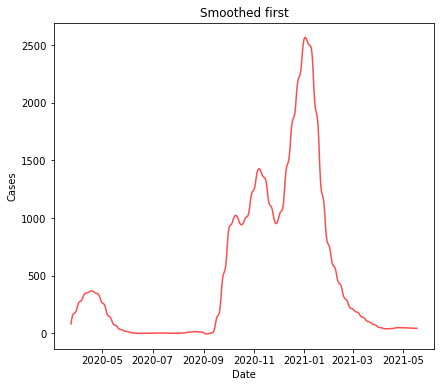

In [20]:
def interpolate_weekly_to_daily (weekly_df, colname, smooth_factor):
    # Copy weekly df to make edits to without influencing original
#     daily_df = weekly_df.copy()
    # Create dataframe with column containing all dates for range between which data is found across any MSOA
    dates =pd.DataFrame({'Date':pd.date_range(start = '2020-03-24', end = '2021-05-18', freq='D')})
    # Create list to store the new daily cases values
    # Populate it with one value. This corresponds to the first week for which there is data. Divide this by 7
    # and include it once, as other days it refers to are not included. 
    new_cases_ls =[(weekly_df[colname][0])/7]
    # Loop through each week, find 1/7th of the weekly values and add it to the list of values 7 times
    # these will be assigned to each day in the week (ending on the week date)
    for i in range(1, len(weekly_df)):
        cases_this_week = weekly_df[colname][i]
        date = weekly_df['Date'][i]
        cases_each_day_this_week = cases_this_week/7
        new_cases_ls.extend(repeat(cases_each_day_this_week, 7))
    # Create dataframe
    daily_df =pd.DataFrame({'Date':dates['Date'],
                       'ShiftedInfections':new_cases_ls})
    # Smooth data
    daily_df =smooth_with_cubic_splines(daily_df.copy(), smooth_factor)
    return daily_df

# Interpolated
daily_cases_devon_shifted_mxpld_smoothed = interpolate_weekly_to_daily (weekly_cases_devon_shifted_mxpld_smoothed, 'SmoothedShiftedInfections', 0.3)

# Plot to test
fig, ax = plt.subplots(figsize =(15,6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
# plt.plot(test2['Date'], test2['ShiftedInfections'], label="Original", color="black", alpha = 1)
plt.plot(daily_cases_devon_shifted_mxpld_smoothed['Date'], daily_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label="Original", color="red", alpha = 0.7)
plt.title("Smoothed first")
plt.xlabel('Date')
plt.ylabel('Cases')

### Individual MSOAs

#### Shifting and multiplying case data

In [21]:
# Specify smooth_factor
smooth_factor1 = 0.8
smooth_factor2 = 0.4

# Create lists to store each MSOA dataframe from loop
shifted_dfs = []
shifted_multiplied_dfs = []
shifted_mxpld_smoothed_dfs = []
shifted_mxpld_smoothed_intrpltd_dfs = []

# Loop through each MSOA, extract data for just that MSOA
# shift cases, multiply cases and save to lists (to convert 
# later back into one dataframe with just shfited data and 
# one with just multiplied data - one column per MSOA)
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = weekly_cases_msoas[['Date', msoa_code]]
    one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
    one_msoa.reset_index(drop = True, inplace = True)
    # # Shift cases
    one_msoa_shifted = shift_cases(one_msoa, 6)
    # Multiply cases
    one_msoa_shifted_multiplied = apply_multipliers(one_msoa_shifted)
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0

    # rename column for shifted cases
    one_msoa_shifted = one_msoa_shifted.rename(columns={"ShiftedCases":msoa_code})
    # rename column for shifted, multiplied cases
    one_msoa_shifted_multiplied = one_msoa_shifted_multiplied.rename(columns={"ShiftedInfections":msoa_code})
    one_msoa_shifted_multiplied = one_msoa_shifted_multiplied.drop(['ShiftedCases'], axis=1)
    # rename column for shifted, multiplied, smoothed cases
    one_msoa_shifted_mxplied_smoothed = one_msoa_shifted_mxplied_smoothed.rename(columns={"SmoothedShiftedInfections":msoa_code})
    one_msoa_shifted_mxplied_smoothed = one_msoa_shifted_mxplied_smoothed.drop(['ShiftedCases', 'ShiftedInfections'], axis=1)
    # rename column for shifted, multiplied, smoothed, interpolated cases
    one_msoa_shifted_mxplied_smoothed_interpolated = one_msoa_shifted_mxplied_smoothed_interpolated.rename(columns={"SmoothedShiftedInfections":msoa_code})
    # reset any value <0.01 as 0
#     one_msoa_shifted_mxplied_smoothed[msoa_code].values[one_msoa_shifted_mxplied_smoothed[msoa_code] < 0] = 0
    
    # Add to shifted dataframe list
    if msoa_code == msoa_codes[0]:
        shifted_dfs.append(one_msoa_shifted[['Date',msoa_code]])
        shifted_multiplied_dfs.append(one_msoa_shifted_multiplied[['Date',msoa_code]])
        shifted_mxpld_smoothed_dfs.append(one_msoa_shifted_mxplied_smoothed[['Date',msoa_code]])
        shifted_mxpld_smoothed_intrpltd_dfs.append(one_msoa_shifted_mxplied_smoothed_interpolated[['Date',msoa_code]]) 
    else:
        shifted_dfs.append(one_msoa_shifted[[msoa_code]])
        shifted_multiplied_dfs.append(one_msoa_shifted_multiplied[[msoa_code]])   
        shifted_mxpld_smoothed_dfs.append(one_msoa_shifted_mxplied_smoothed[[msoa_code]])   
        shifted_mxpld_smoothed_intrpltd_dfs.append(one_msoa_shifted_mxplied_smoothed_interpolated[[msoa_code]])           
        
# Join list of dataframes into one - shifted       
weekly_cases_msoas_shifted = pd.concat(shifted_dfs, axis=1)
# Join list of dataframes into one - multiplied        
weekly_cases_msoas_shifted_mltpld = pd.concat(shifted_multiplied_dfs, axis=1)
# Join list of dataframes into one - smoothed        
weekly_cases_msoas_shifted_mltpld_smoothed = pd.concat(shifted_mxpld_smoothed_dfs, axis=1)
# Join list of dataframes into one - interpolated        
daily_cases_msoas_shifted_mltpld_smoothed = pd.concat(shifted_mxpld_smoothed_intrpltd_dfs, axis=1)


#### Plot for some msoas to test

In [106]:
# msoa_codes = weekly_cases_msoas.columns[1:]
# fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
# for i, ax in enumerate(fig.axes):
#     msoa_code = msoa_codes[i]
#     # Plot observations
# #     ax.plot(weekly_cases_msoas['Date'], weekly_cases_msoas[msoa_code], label="Original cases", color="orange")
# #     ax.plot(weekly_cases_msoas_shifted['Date'], weekly_cases_msoas_shifted[msoa_code], label="Shifted cases", color="blue")
#     ax.plot(weekly_cases_msoas_shifted_mltpld['Date'], weekly_cases_msoas_shifted_mltpld[msoa_code], label="Shifted infections", color="green")
#     ax.plot(weekly_cases_msoas_shifted_mltpld_smoothed['Date'], weekly_cases_msoas_shifted_mltpld_smoothed[msoa_code], label="Smoothed shifted infections", color="purple")
#     ax.tick_params(axis='x', labelrotation=45, labelsize = 15 )
#     ax.legend(fontsize =15)
# # plt.suptitle("Comparing weekly data with weekly sums from daily data")
# fig.tight_layout()
# plt.show()

#### Plot interpolated data for some MSOAs

Text(0, 0.5, 'Cases')

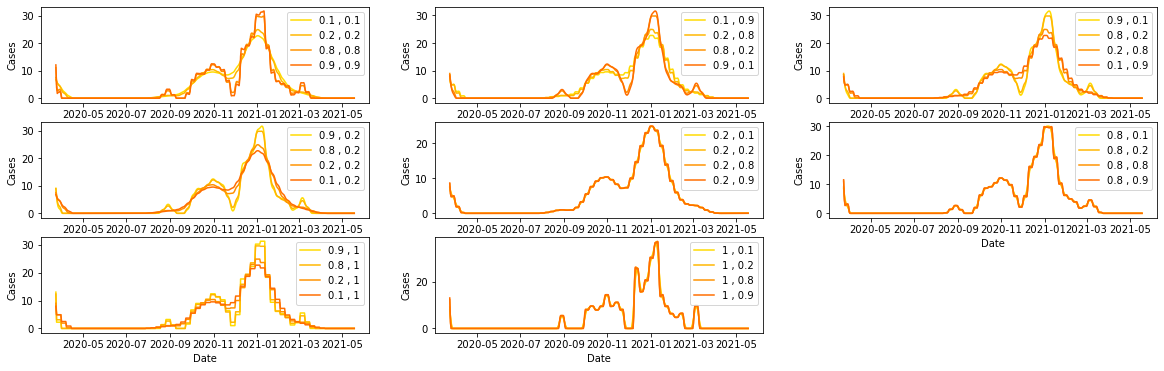

In [23]:
msoa_code = msoa_codes[0]

# Take just one msoa's data, and format
one_msoa = weekly_cases_msoas[['Date', msoa_code]]
one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
one_msoa.reset_index(drop = True, inplace = True)
# # Shift cases
one_msoa_shifted = shift_cases(one_msoa, 6)
# Multiply cases
one_msoa_shifted_multiplied = apply_multipliers(one_msoa_shifted)


fig, ax = plt.subplots(figsize =(20,6))
plt.subplot(3, 3, 1) # row 1, col 2 index 1
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5], [0.1,0.2,0.8, 0.9], [0.1,0.2,0.8, 0.9]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

plt.subplot(3, 3, 2) # index 2
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5], [0.1,0.2,0.8, 0.9], [0.9,0.8,0.2, 0.1]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

plt.subplot(3, 3, 3) # index 2
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5],[0.9,0.8,0.2, 0.1], [0.1,0.2,0.8, 0.9]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

plt.subplot(3, 3, 4) # index 2
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5],[0.9,0.8,0.2, 0.1], [0.2,0.2,0.2,0.2]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

plt.subplot(3, 3, 5) # index 2
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5],[0.2,0.2,0.2,0.2], [0.1,0.2,0.8, 0.9]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

plt.subplot(3, 3, 6)
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5],[0.8,0.8,0.8,0.8], [0.1,0.2,0.8, 0.9]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

########################################################################
########################################################################
# 
########################################################################
########################################################################
plt.subplot(3, 3, 7) 
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5],[0.9,0.8,0.2, 0.1], [1,1,1,1]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

plt.subplot(3, 3, 8) # index 2
for color_i, smooth_factor1, smooth_factor2 in zip([1,2,3,4,5],[1,1,1,1], [0.1,0.2,0.8, 0.9]):
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor1)
    # # Interpolate cases
    one_msoa_shifted_mxplied_smoothed_interpolated = interpolate_weekly_to_daily(one_msoa_shifted_mxplied_smoothed, 'SmoothedShiftedInfections', smooth_factor2)
    one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'].values[one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'] < 0] = 0
    color = colors[color_i]
    # Plot observations
    plt.plot(one_msoa_shifted_mxplied_smoothed_interpolated['Date'], one_msoa_shifted_mxplied_smoothed_interpolated['SmoothedShiftedInfections'], label=str(smooth_factor1)+' , ' +str(smooth_factor2), color = color)
plt.legend()
# plt.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")

# Smooth factor1 = on weekly data
# Smooth factor2 = on daily data

# if don't smooth daily data, then data doesn't end up looking smooth
# if don't smooth weekly data, then smoothing afterwards doesn't make much difference 

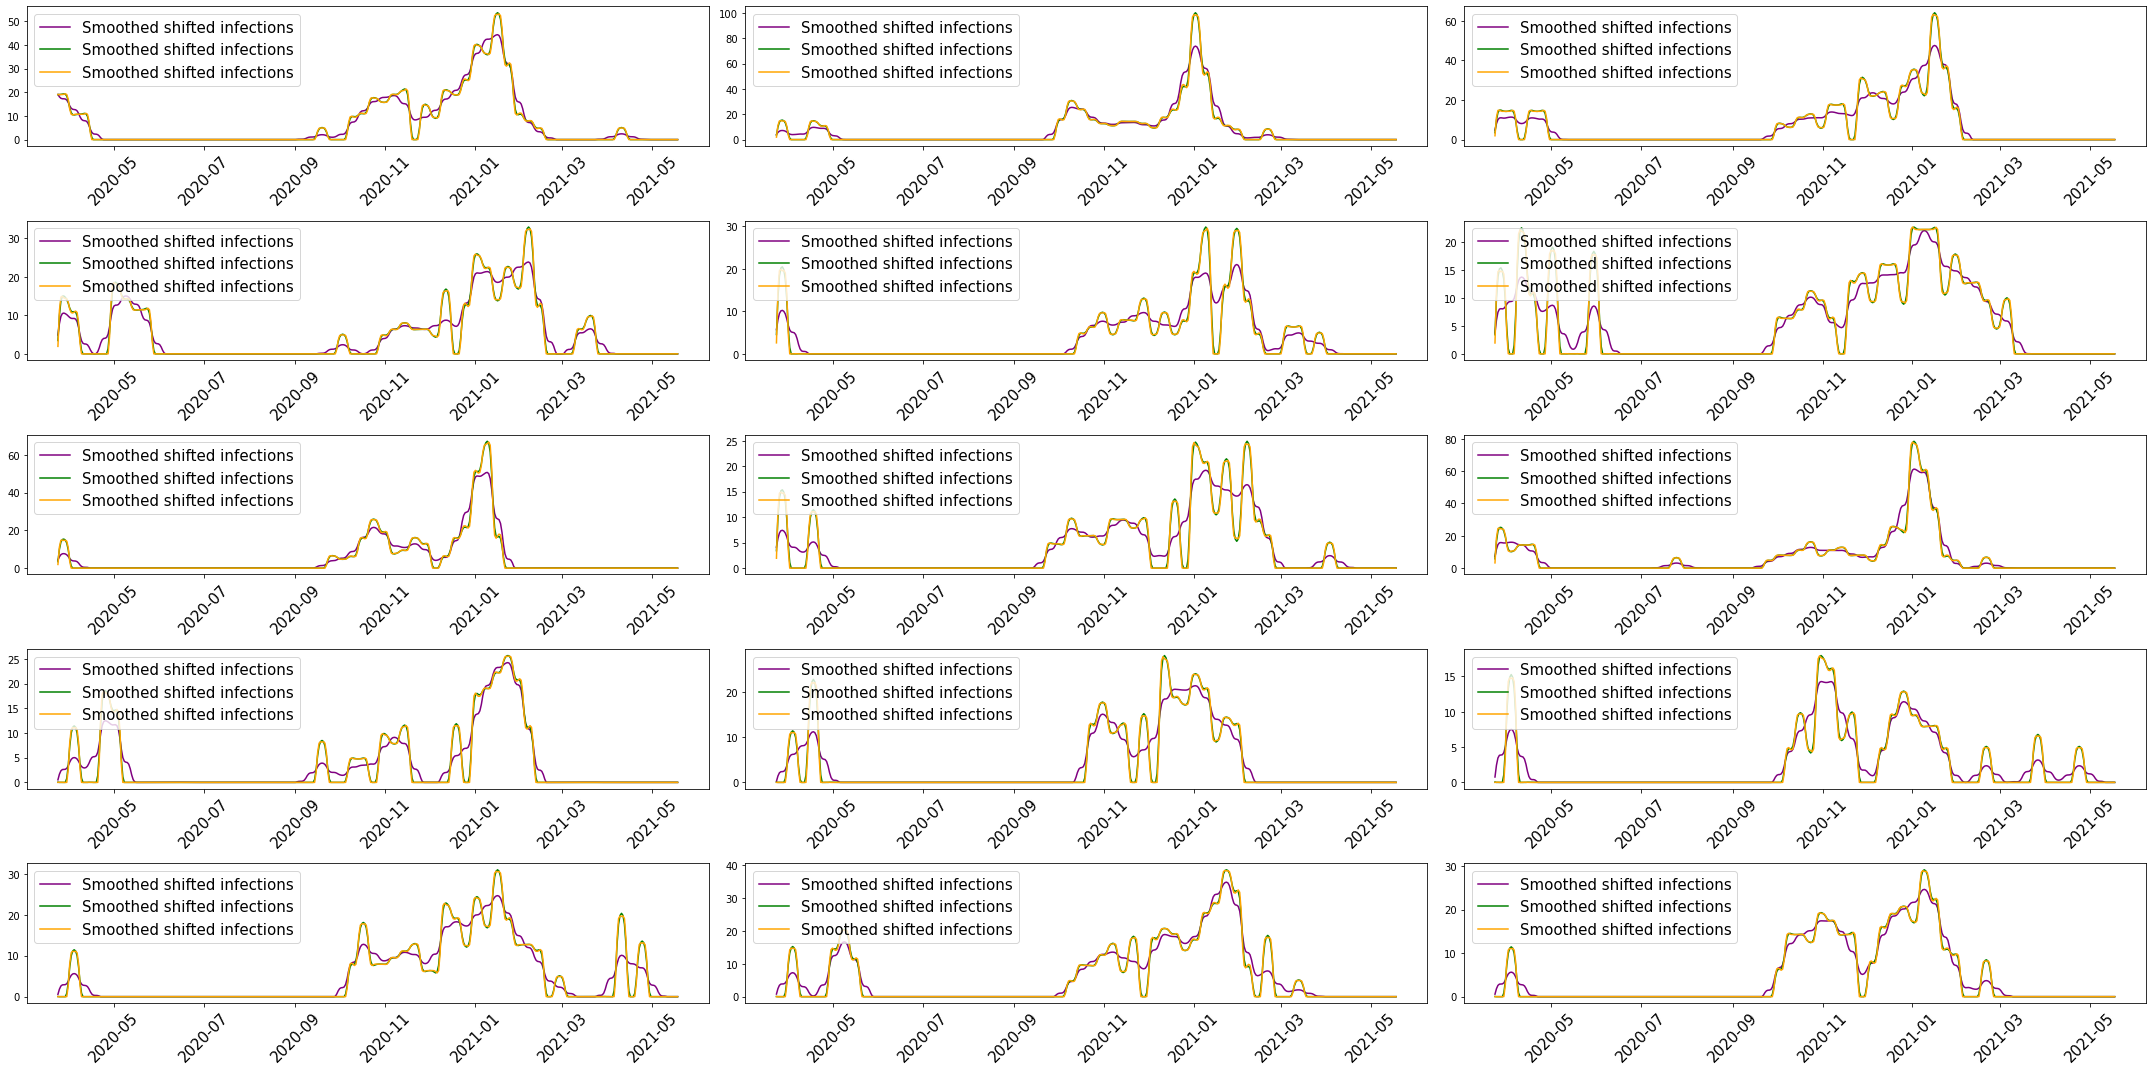

In [116]:
daily_cases_msoas_shifted_mltpld_smoothed
fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
for i, ax in enumerate(fig.axes):
    msoa_code = msoa_codes[i]
    # Plot observations
    ax.plot(daily_cases_msoas_shifted_mltpld_smoothed['Date'], daily_cases_msoas_shifted_mltpld_smoothed[msoa_code], label="Smoothed shifted infections", color="purple")
    ax.plot(daily_cases_msoas_shifted_mltpld_smoothed_0_5['Date'], daily_cases_msoas_shifted_mltpld_smoothed_0_5[msoa_code], label="Smoothed shifted infections", color="green")
    ax.plot(daily_cases_msoas_shifted_mltpld_smoothed_0_8['Date'], daily_cases_msoas_shifted_mltpld_smoothed_0_8[msoa_code], label="Smoothed shifted infections", color="orange")
    ax.tick_params(axis='x', labelrotation=45, labelsize = 15 )
    ax.legend(fontsize =15)
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
fig.tight_layout()
plt.show()

#### Save the corrected case data to file

In [119]:
# save shifted, multiplied, smoothed data
weekly_cases_msoas_shifted_mltpld_smoothed.to_csv("weekly_cases_msoas_corrected.csv", index= False, float_format='%6g')
# save shifted, multiplied, smoothed, interpolated data
daily_cases_msoas_shifted_mltpld_smoothed.to_csv("daily_cases_msoas_corrected.csv", index= False, float_format='%6g')